# Deep Learning Featured Model Training

This is the notebook used for training the CNN models in the Deep learning section of the report.
Notes: 
* Multiple combinations of data and hyper parameters were evaluated with a classic CNN architecture
* Trained models are then saved as .keras files with descriptive naming conventions indicating the settings used for training. 
* This notebook as saved can recreate the training of the "Chosen Model" for both MFCC and Log Melspectrogram scenarios.  For recreating other scenarios, you may need to modify some settings. 
* The separate deep_learning_model_evaluation notbook has comparative evaluations across multiple modeling scenarios for each of the two feature types. In this notebook, it demonstrates the righ way to load and process data to properly evaluate each scenario.  It also shows the file names for each scenario. 

In [1]:
import sys
sys.path.insert(0, '../../')
from library.notebook_api.deep_learning_training_data import get_feature_vector_data,get_augmented_x_y
from library.notebook_api.deep_learning_models import  get_2d_cnn
from library.notebook_api.model_evaluation import plot_training_history, ModelEvaluation
from configuration import SAVED_MODEL_PATH
from tensorflow import keras
import numpy as np

2024-12-08 19:07:58.333911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Scenario 1: Using MFCC 13X500 feature vector
This section utilizes the Mel Frequency Cepstrum Coefficient feature, downsampled to 22500 khz


In [2]:
X_train, X_test, y_train, y_test,label_encoder =get_feature_vector_data(vector_type = 'mfcc',
                                                        version_string = '006',
                                                        vector_length = 500,
                                                        #vector_length = 1000,  
                                                        apply_normalization = True,
                                                        apply_resampling=True)

Loading mfcc vectors
features shape distribution
1099    20865
1         221
293         2
173         2
862         2
392         1
467         1
201         1
946         1
622         1
Name: count, dtype: int64
total records:  21164
normalized length:  20865
Row Count after label based filter:  21164
Final Row count after label and feature filter:  20865
Unique label count:  6
label data count  20865
Truncate features to consistent length and reshape
Generate train_test_split for test size  0.2
applying normalization
apply random oversampler on train data


In [ ]:
'''
#this section is to over-write the data with augmented data 
#It is commented out as the "chosen model" for mfcc did not involve augmentation
#the augmented data process slices the original audio features into several overlapping segments
#there are also settings which can influence the resulting balance of the data 

X_train, y_train  = get_augmented_x_y(X_train, 
                                    y_train, 
                                    num_segments=5, 
                                    overlap_factor=.3,
                                    row_resample_weight_100_perc_thresh=.9,
                                    discount_weight_factor=.25
                                    )
'''
'''
X_test, y_test  = get_augmented_x_y(X_test, 
                                    y_test, 
                                    num_segments=5, 
                                    overlap_factor=.3,
                                    row_resample_weight_100_perc_thresh=.9,
                                    discount_weight_factor=.25
                                    )
'''

creating augmented data with segment boundaries [[0, 260], [200, 460], [400, 660], [600, 860], [739, 999]]
weights to resample labels are [0.93705079 0.98592477 0.68501437 0.82672496 0.9679564  0.5973287 ]
creating augmented data with segment boundaries [[0, 260], [200, 460], [400, 660], [600, 860], [739, 999]]
weights to resample labels are [0.93700599 0.98586826 0.68502994 0.82682635 0.96790419 0.59736527]


In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40320, 500, 13, 1), TensorShape([4173, 500, 13, 1]), (40320, 6), (4173, 6))

In [4]:
np.unique(np.argmax(y_train,axis=1),return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([6720, 6720, 6720, 6720, 6720, 6720]))

In [5]:
selected_hp = {'learning_rate':  0.0001}
#selected_hp = {'learning_rate':  0.001}

type(selected_hp)
model_1 = get_2d_cnn(selected_hp)


In [ ]:
history = model_1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    
    #batch_size=32,
    #batch_size=64,
    batch_size = 128,
    epochs=200,
    #epochs = 50,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),

    ]
)

Epoch 1/200
211/315 [===================>..........] - ETA: 33s - loss: 1.3171 - accuracy: 0.4935

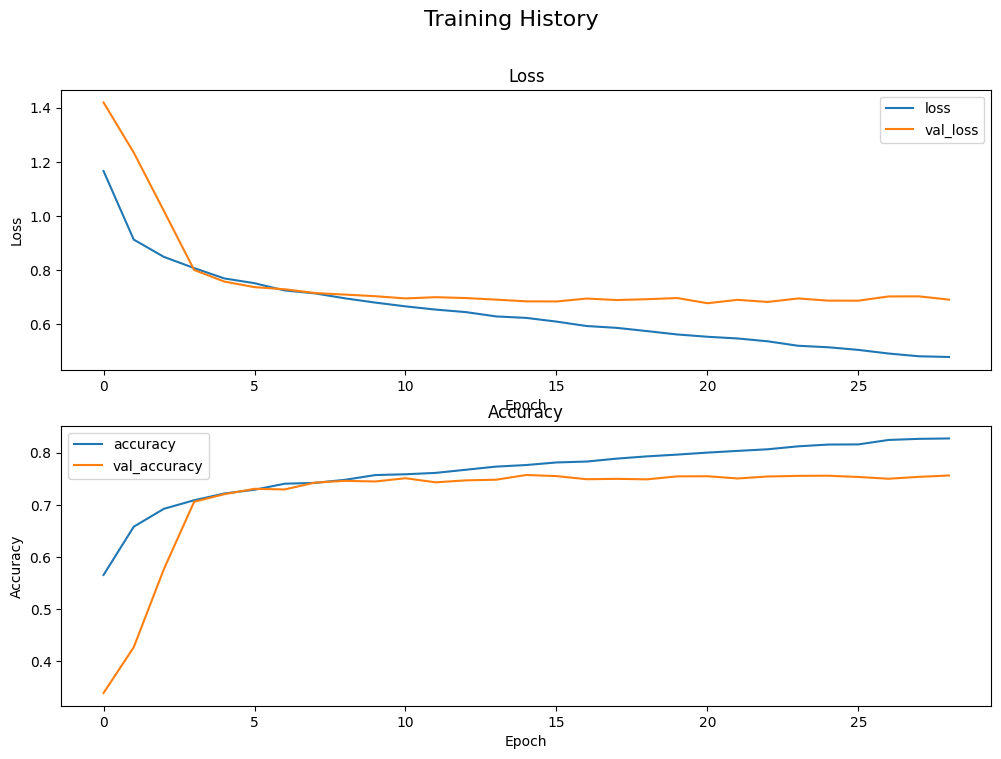

In [ ]:
plot_training_history(history)

In [ ]:
model_1_name = 'CNN_MFCC'
#model_1_file_name = 'v6c_mfcc_scaled_128_22500_500_cnn_2d_128_batch_200_epoch_lr_0001.keras'
model_1_file_name = 'v6c_mfcc_scaled_resampled_128_22500_500_cnn_2d_128_batch_200_epoch_lr_0001_002.keras'

model_1.save(SAVED_MODEL_PATH+model_1_file_name)

In [ ]:
model_1 = ModelEvaluation(model_1_name,model_1_file_name,X_test, y_test, label_encoder)

131/131 [==============================] - 4s 33ms/step


Evaluating Model:  CNN_MFCC
131/131 - 4s - loss: 0.6783 - accuracy: 0.7547 - 4s/epoch - 33ms/step

Test Accuracy: 75.47%
Test Loss: 0.6783

Classification Report:
              precision    recall  f1-score   support

   classical       0.83      0.81      0.82       263
     country       0.00      0.00      0.00        59
  electronic       0.72      0.74      0.73      1315
      hiphop       0.74      0.71      0.73       724
        jazz       0.60      0.13      0.22       134
        rock       0.78      0.85      0.81      1687

    accuracy                           0.75      4182
   macro avg       0.61      0.54      0.55      4182
weighted avg       0.74      0.75      0.74      4182



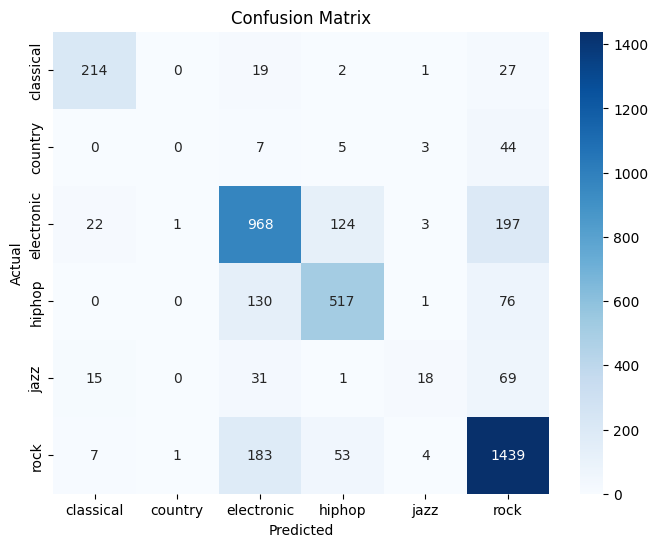

In [ ]:
model_1.evaluate()

## Scenario 2: Using Log MelSepctrogram 128X500 feature vector

This section utilizes Log Mel Spectrograms for training 

In [2]:
X_train, X_test, y_train, y_test,label_encoder =get_feature_vector_data(vector_type = 'log_mel',
                                                        version_string = '006',
                                                        vector_length = 500, 
                                                        #vector_length = 1000, 
                                                        apply_normalization = True,
                                                        apply_resampling=False
                                                        )

Loading log mel vectors
features shape distribution
1099    20865
1         221
293         2
173         2
862         2
392         1
467         1
201         1
946         1
622         1
Name: count, dtype: int64
total records:  21164
normalized length:  20865
Row Count after label based filter:  21164
Final Row count after label and feature filter:  20865
Unique label count:  6
label data count  20865
Truncate features to consistent length and reshape
Generate train_test_split for test size  0.2
applying normalization


In [3]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(TensorShape([16692, 500, 128, 1]),
 TensorShape([4173, 500, 128, 1]),
 (16692, 6),
 (4173, 6))

In [4]:
#for checking the class balance
np.unique(np.argmax(y_train,axis=1),return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([1051,  235, 5260, 2891,  535, 6720]))

In [5]:
selected_hp = {'learning_rate':  0.0001}
#selected_hp = {'learning_rate':  0.001}

type(selected_hp)
model_2 = get_2d_cnn(selected_hp)

In [6]:
history = model_2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    
    #batch_size=32,
    #batch_size=64,
    batch_size = 128,
    #epochs=200,
    epochs = 200,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),

    ]
)

Epoch 1/200
131/131 [==============================] - 613s 5s/step - loss: 1.0083 - accuracy: 0.6370 - val_loss: 1.5869 - val_accuracy: 0.5454
Epoch 2/200
131/131 [==============================] - 583s 4s/step - loss: 0.7594 - accuracy: 0.7283 - val_loss: 2.4106 - val_accuracy: 0.3757
Epoch 3/200
131/131 [==============================] - 606s 5s/step - loss: 0.6444 - accuracy: 0.7666 - val_loss: 1.5507 - val_accuracy: 0.5572
Epoch 4/200
131/131 [==============================] - 517s 4s/step - loss: 0.5499 - accuracy: 0.7997 - val_loss: 0.8505 - val_accuracy: 0.7043
Epoch 5/200
131/131 [==============================] - 515s 4s/step - loss: 0.4595 - accuracy: 0.8333 - val_loss: 0.7202 - val_accuracy: 0.7541
Epoch 6/200
131/131 [==============================] - 529s 4s/step - loss: 0.3828 - accuracy: 0.8605 - val_loss: 0.6765 - val_accuracy: 0.7644
Epoch 7/200
131/131 [==============================] - 519s 4s/step - loss: 0.3177 - accuracy: 0.8880 - val_loss: 0.6923 - val_accuracy:

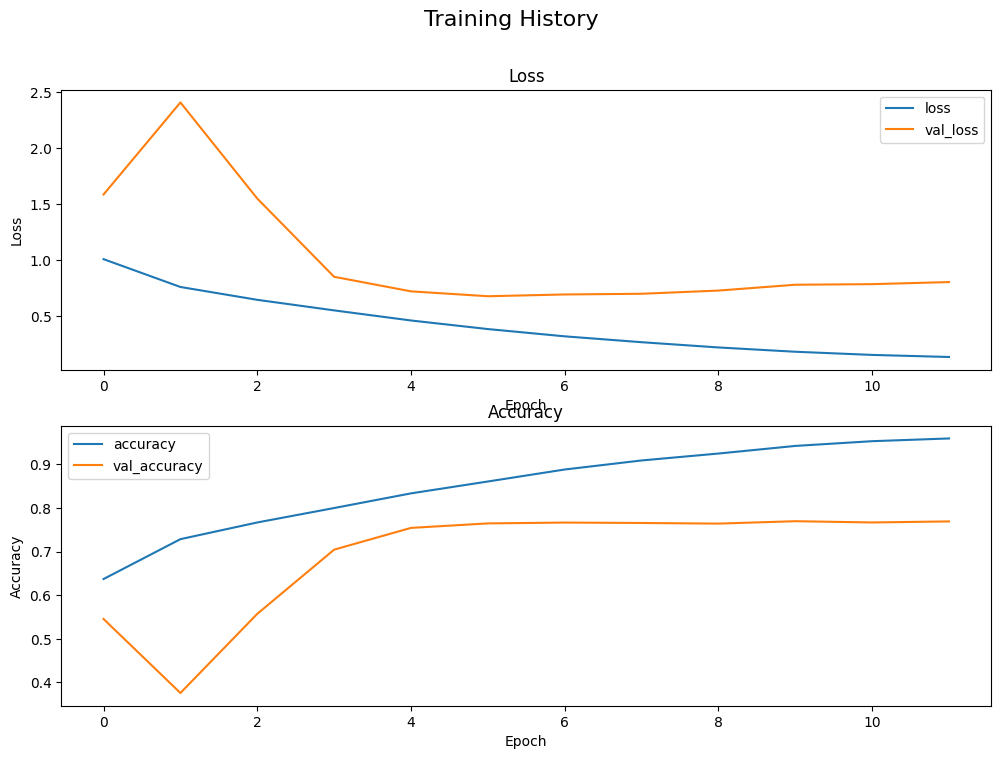

In [7]:
plot_training_history(history)

In [8]:
model_2_name = 'CNN_LogMel'
#model_2_file_name = 'v6b_logmel_scaled_128_22500_500_cnn_2d_128_batch_18_epoch_lr_0001.keras'
#was actually set to 200 epic but early stopped at 18
#model_2_file_name = 'v6c_logmel_scaled_resampledsegment625_128_22500_1000_cnn_2d_128_batch_18_epoch_lr_0001.keras'
#model_2_file_name = 'v6c_logmel_unscaled_resampledsegment430_128_22500_1000_cnn_2d_128_batch_200_epoch_lr_0001.keras'
#model_2_file_name='v6c_log_scaled_resampled_128_22500_500_cnn_2d_128_batch_200_epoch_lr_0001.keras'
model_2_file_name='v6c_log_scaled_128_22500_500_cnn_2d_128_batch_200_epoch_lr_0001.keras'


model_2.save(SAVED_MODEL_PATH+model_2_file_name)

131/131 [==============================] - 31s 234ms/step
Evaluating Model:  CNN_LogMel
131/131 - 36s - loss: 0.6765 - accuracy: 0.7644 - 36s/epoch - 275ms/step

Test Accuracy: 76.44%
Test Loss: 0.6765

Classification Report:
              precision    recall  f1-score   support

   classical       0.74      0.79      0.76       263
     country       0.00      0.00      0.00        59
  electronic       0.74      0.73      0.73      1314
      hiphop       0.75      0.72      0.74       723
        jazz       0.49      0.33      0.39       134
        rock       0.80      0.87      0.84      1680

    accuracy                           0.76      4173
   macro avg       0.59      0.57      0.58      4173
weighted avg       0.75      0.76      0.76      4173



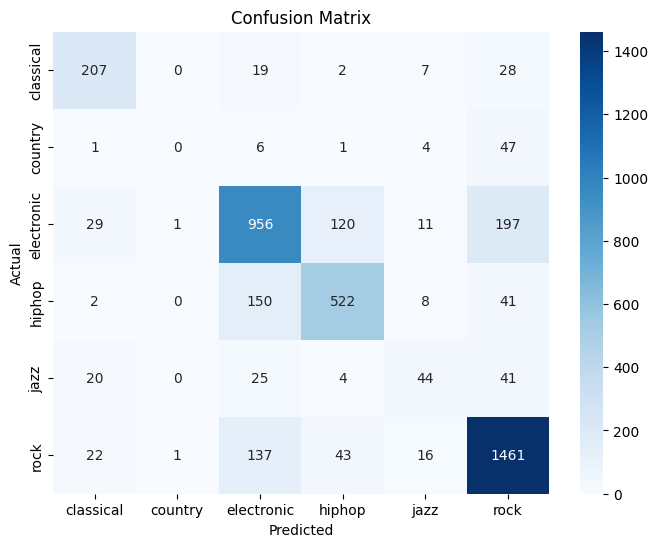

In [9]:
model_2 = ModelEvaluation(model_2_name,model_2_file_name,X_test, y_test, label_encoder)
model_2.evaluate()



#https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive.
Precision is a good measure to determine, when the costs of False Positive is high. For instance, email spam detection

Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.


f1 = 2 x( (precions*recall)/(recision+recal))

F1 Score is needed when you want to seek a balance between Precision and Recall. Right…so what is the difference between F1 Score and Accuracy then? We have previously seen that accuracy can be largely contributed by a large number of True Negatives which in most business circumstances, we do not focus on much whereas False Negative and False Positive usually has business costs (tangible & intangible) thus F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).



Next Notes: 
Deep Learning Code improvements:

-retrain models in featured notebook so that results in paper are reproduced with notebook , and resave (do more epochs)
consider whether to supply validation data from test set OR not (may be incorect )

To do - re-do the main MFCC to confirm results 

-Decision point - either have keras_tuner part of training notebook or remove 



- for the segmentation approach,  create alternate test data scenario:
just one random segment from each track can be grabbed so as to have test data have same shape, but to calculate metrics based on balance of actual data 


Evaluation Chart improvements:
See if can make the confusion matrix align in order to tetyanas for comparability

Other code cleanup:
-- for demo: put functions externally, create cleaned notebook
-- For the data writing, create cleaned notebook, just latest runs describing the versions 
-- consider an 'about the data notebook'
-- deep learning training notebook cleanup, just the scenarios 
-- move supervised, unsupervised into main folder 
-- Readme cleanup including clarity on downloading and using data 

-- comments and doc strings on library




Paper Writing: 
--
remove mention of other deep learning architectures from the other parts of paper 

cleanup and label charts in deep learning 

mention that parameter tuning and rebalancing methods were tried 

summary part 

Video: 
Re-edit version with demo back on T's version 
watch through verify numerical feature gone and see if any oother notes
consider re-record tighter demo , skip not interesting parts go right to the ones that were interesting informed by watching video 
